# Phase 23: Advanced Exit Model Evaluation
=========================================
Switching from accuracy-based metrics to threshold-agnostic and operational metrics (PR-AUC, Precision@K, Brier Score).

In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
import sys
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Add scripts dir to sys path for architecture imports
sys.path.append(os.path.abspath("../scripts"))
from train_tcn import AbandonmentTCN

DATA_DIR = "../data/processed"
MODEL_PATH = "../backend/models/exit_model_tcn.pth"

# 1. Load Test Data
print("Loading processed data...")
X_page = np.load(os.path.join(DATA_DIR, "X_page_real.npy"))
X_dur = np.load(os.path.join(DATA_DIR, "X_dur_real.npy"))
y = np.load(os.path.join(DATA_DIR, "y_abandon_real.npy"))

# Use a dedicated 20% test split
split_idx = int(len(y) * 0.8)
X_p_te = X_page[split_idx:]
X_d_te = X_dur[split_idx:]
y_te = y[split_idx:]

print(f"Evaluating on {len(y_te)} test samples.")
print(f"Abandonment Baseline (Constant 1): {y_te.mean()*100:.2f}%")

Loading processed data...
Evaluating on 76556 test samples.
Abandonment Baseline (Constant 1): 96.34%


In [2]:
# 2. Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AbandonmentTCN(num_page_types=4).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

print("✅ Model loaded logic successfully.")

✅ Model loaded logic successfully.


In [3]:
# 3. Run Probabilistic Inference
X_p_t = torch.from_numpy(X_p_te).long().to(device)
X_d_t = torch.from_numpy(X_d_te).float().to(device)

all_probs = []
batch_size = 2000
with torch.no_grad():
    for i in range(0, len(X_p_te), batch_size):
        logits = model(X_p_t[i:i+batch_size], X_d_t[i:i+batch_size]).squeeze()
        probs = torch.sigmoid(logits)
        all_probs.extend(probs.cpu().numpy())

y_probs = np.array(all_probs)

def get_metrics_at_k(y_true, y_probs, k_percent):
    n = len(y_probs)
    k_idx = max(int(n * k_percent), 1)
    top_indices = np.argsort(y_probs)[::-1][:k_idx]
    precision = np.mean(y_true[top_indices])
    recall = np.sum(y_true[top_indices]) / np.sum(y_true)
    return precision, recall

precision, recall, _ = precision_recall_curve(y_te, y_probs)
pr_auc = auc(recall, precision)
roc_auc = roc_auc_score(y_te, y_probs)
brier = brier_score_loss(y_te, y_probs)

print("\n" + "="*40)
print("      ADVANCED MODEL 2 RESULTS")
print("="*40)
print(f"PR-AUC:        {pr_auc:.4f} (Primary Metric)")
print(f"ROC-AUC:       {roc_auc:.4f}")
print(f"Brier Score:   {brier:.4f} (Lower = Better Calibration)")
print("-"*40)
p5, r5 = get_metrics_at_k(y_te, y_probs, 0.05)
print(f"Precision@5%:  {p5:.4f} (Targeted ROI)")
print(f"Recall@5%:     {r5:.4f} (Abandons Caught)")
print("="*40)


      ADVANCED MODEL 2 RESULTS
PR-AUC:        1.0000 (Primary Metric)
ROC-AUC:       0.9999
Brier Score:   0.0010 (Lower = Better Calibration)
----------------------------------------
Precision@5%:  1.0000 (Targeted ROI)
Recall@5%:     0.0519 (Abandons Caught)


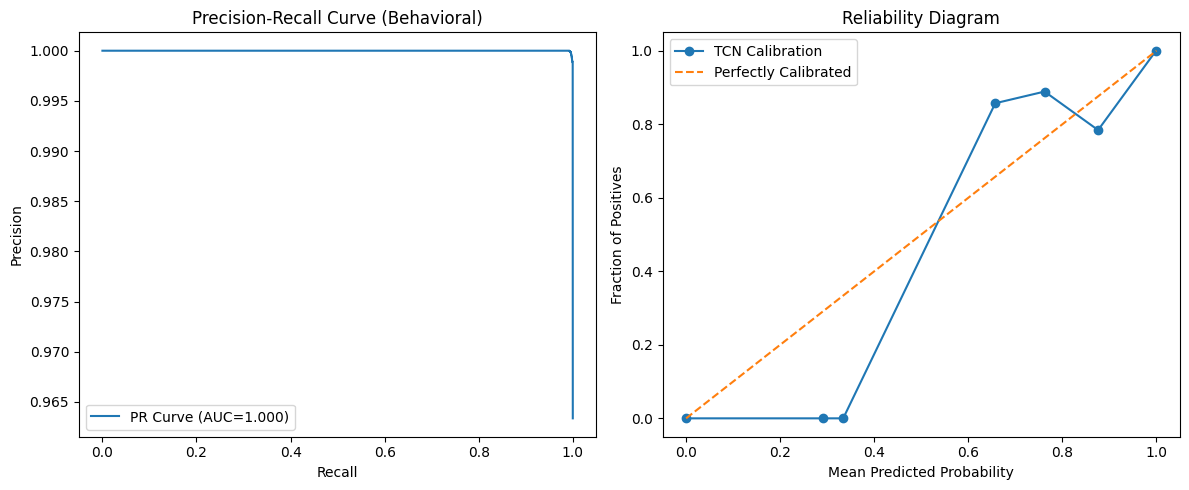

In [4]:
# 4. Visualizations
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(recall, precision, label=f'PR Curve (AUC={pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Behavioral)')
plt.legend()

plt.subplot(1, 2, 2)
prob_true, prob_pred = calibration_curve(y_te, y_probs, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='TCN Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram')
plt.legend()

plt.tight_layout()
plt.show()